# Analyzis of the Kickstarter Dataset
This dataset contains 378661 projects that occurred on the Kickstarter crowdfunding platform. There are 2 mains objective attributes for which we can be looking for within the data:

* The pledge a project obtains, which is something more interesting to observe from the point of view of Kickstarter itself, since they profit by commission.
* The final state of the projects, because a project can either achieve its pledge goal and succeed or it can fail.

Our goal with this study is to analyze which are the attributes which influence more both of these objectives. Obtaining a good predicting model would be impossible, given that the biggest key to success at Kickstarter are the introduction videos and the offers, which is information we do not contain in our dataset. Therefore, our main goal is to analyze inference of the attributes on our objectives.

## Loading the data

In [15]:
data <- read.csv("datasets/ks-projects-201801_WithOtherActive.csv",header=T,na.strings="?")
dim(data)

[1] 378661     16

## Analyzing the existing attributes

The `other_active_projects` was created by the team using a Java program. It contains the number of projects that were active at the the of launch of that project. We simply had a hunch it would be relevant

In [16]:
names(data)

[1] "ID"                    "name"                  "category"             
 [4] "main_category"         "currency"              "deadline"             
 [7] "goal"                  "launched"              "pledged"              
[10] "state"                 "backers"               "country"              
[13] "usd_pledged"           "usd_pledged_real"      "usd_goal_real"        
[16] "other_active_projects"

## Entry removal

Removing attributes which were not finished (at the time of the snapshot) yet or had wierd status.

In [17]:
data <- data[data$state %in% c("successful", "failed"),]
dim(data)

[1] 331675     16

## Column removal
Removing columns which shouldn't be used or do not tend to be useful
* `goal` because we have `usd_goal_real` which is all in the same currency.
* `pledge` and `usd_pledged` because we have `usd_pledged_real`.
* `state` because we don't want it for the `usd_pledged_real` regression and we can recreate it with the simple condition `usd_pledged_real > usd_goal_real`
* `backers` because that is part of the final result

In [18]:
projects <- data[,-c(7, 9, 10, 11, 13)]
names(projects)

[1] "ID"                    "name"                  "category"             
 [4] "main_category"         "currency"              "deadline"             
 [7] "launched"              "country"               "usd_pledged_real"     
[10] "usd_goal_real"         "other_active_projects"

### Transforming the factors into strings

In [19]:
projects$launched <- as.character(projects$launched)
projects$deadline <- as.character(projects$deadline)
projects$category <- as.character(projects$category)
projects$main_category <- as.character(projects$main_category)
projects$country <- as.character(projects$country)
projects$currency <- as.character(projects$currency)

## Now let's understand the attributes, one by one

### ID

In [20]:
length(unique(projects$ID))

[1] 331675

Most likely the ID won't be useful in any way.

## Name

In [21]:
length(unique(projects$name))

[1] 329595

Not useful as it is, but has potencial to extract other features, for example, the number of words in it:

### wordcount

In [29]:
projects$wordcount <- lengths(strsplit(as.character(projects$name), "\\W+"))
summary(projects$wordcount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   5.000   5.653   8.000  27.000 

### Launched & Deadline

Sames as with name. Since the time of the year seemed only slightly relevant, we decided to use it:

### month

In [37]:
projects$month <- substring(projects$launched, 6, 7)

In [46]:
projects$success <- projects$usd_pledged_real >= projects$usd_goal_real
tmp <- aggregate(success ~ month, data = projects, FUN = mean)

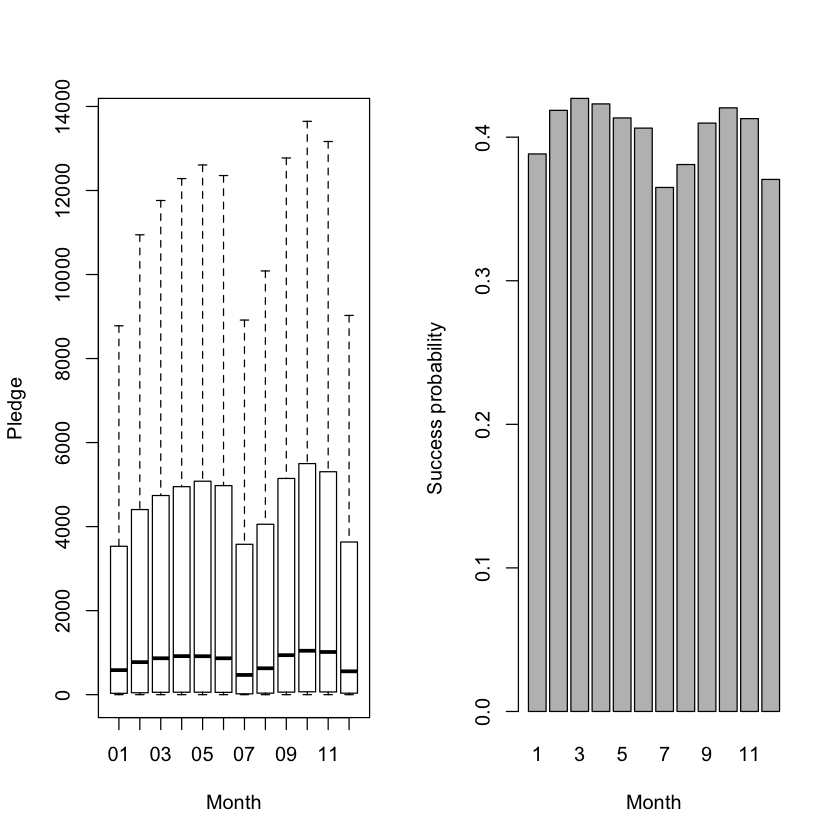

In [45]:
par(mfrow = c(1,2))
boxplot(projects$usd_pledged_real ~ projects$month, outline = F, xlab = "Month", ylab = "Pledge")
barplot(tmp$success, names.arg = 1:12, xlab = "Month", ylab = "Success probability")

Now let's check if the duration of the project can be important

### duration

In [31]:
projects$duration <- as.numeric(difftime(as.Date(projects[,"deadline"]), as.Date(projects[,"launched"])))
summary(projects$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   30.00   30.00   33.95   36.00   92.00 

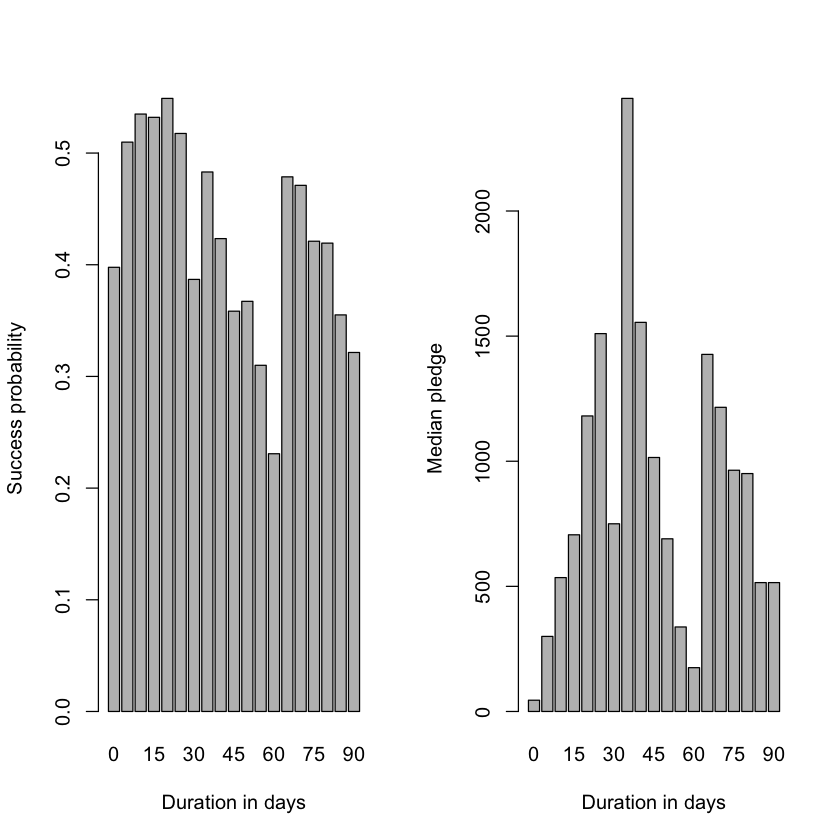

In [58]:
tmp <- aggregate(success ~ duration%/% 5, data = projects, FUN = mean)
par(mfrow = c(1,2))
barplot(tmp$success, names.arg = seq(0,90,5), xlab = "Duration in days", ylab = "Success probability")
tmp <- aggregate(usd_pledged_real ~ duration%/% 5, data = projects, FUN = median)
barplot(tmp$usd_pledged_real, names.arg = seq(0,90,5), xlab = "Duration in days", ylab = "Median pledge")

### Category & Main Category

In [22]:
unique(projects$main_category)

[1] "Publishing"   "Film & Video" "Music"        "Food"         "Crafts"      
 [6] "Games"        "Design"       "Comics"       "Fashion"      "Theater"     
[11] "Art"          "Photography"  "Technology"   "Dance"        "Journalism"

The high number of different values for this nominal attribute might be a problem.

In [23]:
length(unique(projects$category))

[1] 159

Besides, as we can observe here, there are a few categories that exist in several main categories, which must be handled, otherwise we will have redundat information.

In [24]:
tmp <- unique((projects[,c("category", "main_category")]))
dim(tmp)

[1] 170   2

In [25]:
library(plyr)
c <- count(tmp, 'category')
c[c$freq > 1,]

,category,freq
7,Anthologies,2
25,Comedy,4
45,Events,2
46,Experimental,2
54,Festivals,2
82,Letterpress,2
135,Spaces,3
152,Web,2


### categoryconcat
The problems noted before were simple to deal with. We just replaced the Category and the Main Category attributes with one that is the concatenation of both

In [26]:
projects$categoryconcat <- paste(projects$main_category, projects$category, sep = " - ")
projects <- projects[,-c(3,4)]
length(unique(projects$categoryconcat))

[1] 170